In [1]:
import sys

sys.path.append("../../") # go to parent dir

In [2]:
from sklearn.linear_model import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
pd.options.display.max_columns = 50 # para mostrar todas las columnas

#### Evaluación para altura de las olas
(nos fijaremos en los mjeores modelos segun raiz de ECM

In [4]:
# Para el modelo con todas las variables
X_train, X_test, y_train, y_test = sep_train_test()
# Eliminamos las columnas repetidas y las columnas temporales (visto en el notebook del analisis)
X_train = X_train.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])
X_test = X_test.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])

In [5]:
def class_ola(ola):
    if (ola < 1):
        return "x<1"
    if (ola < 2):
        return "1<x<2"
    if (ola < 3):
        return "2<x<3"
    else:
        return "x>3"

In [6]:
ola_clas = y_test.map(class_ola)

In [21]:
def evaluate_wave_error_distr(model_name, x_te = None):
    flo = MLFlow()

    model = flo.get_saved_model(model_name)
    if x_te is None:
        x_te = X_test
    olas_err = pd.DataFrame({"ola": ola_clas, "error": y_test - model.predict(x_te)})
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    for i, o in enumerate(olas_err.ola.unique()):
        ax[i//2, i%2].hist(olas_err[olas_err["ola"] == o].error, label=o, density=True)
        ax[i//2, i%2].set_title(o)

#### LinearModel

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


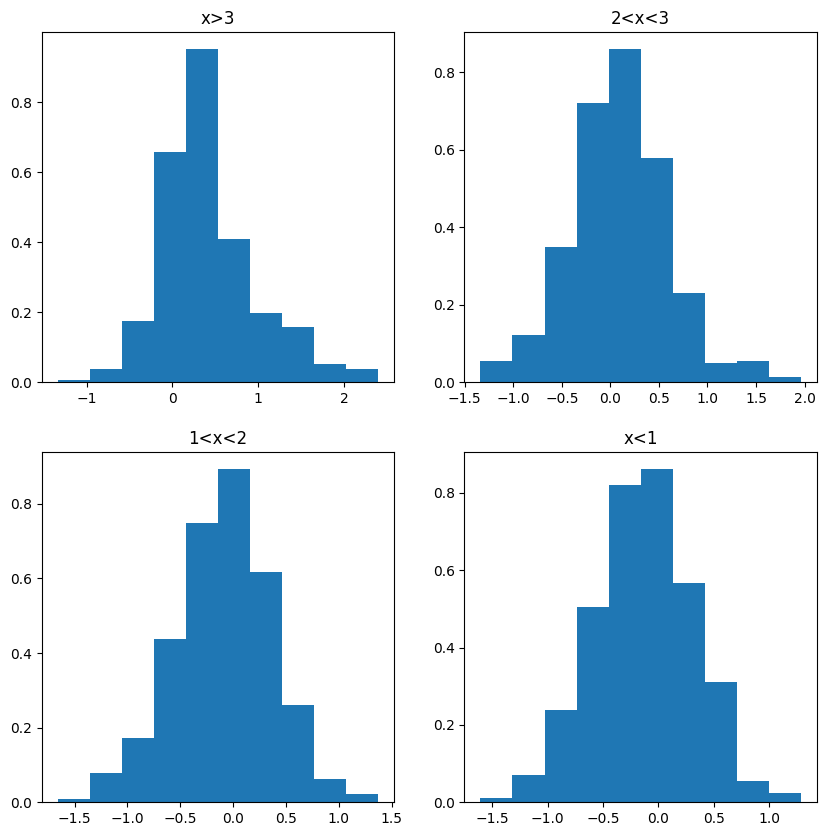

In [12]:
evaluate_wave_error_distr("lineal-sin-regularizar")

#### Ridge

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


Text(0.5, 0.98, 'RIDGE')

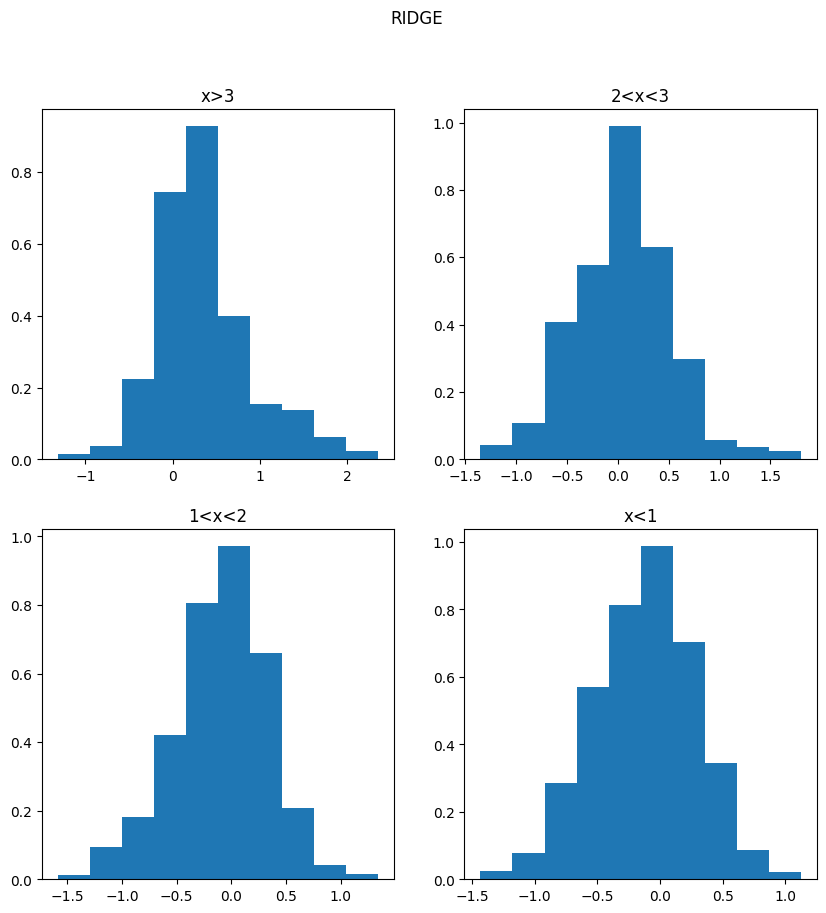

In [10]:
evaluate_wave_error_distr("ridge_random")
plt.suptitle("RIDGE")

#### Lasso

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


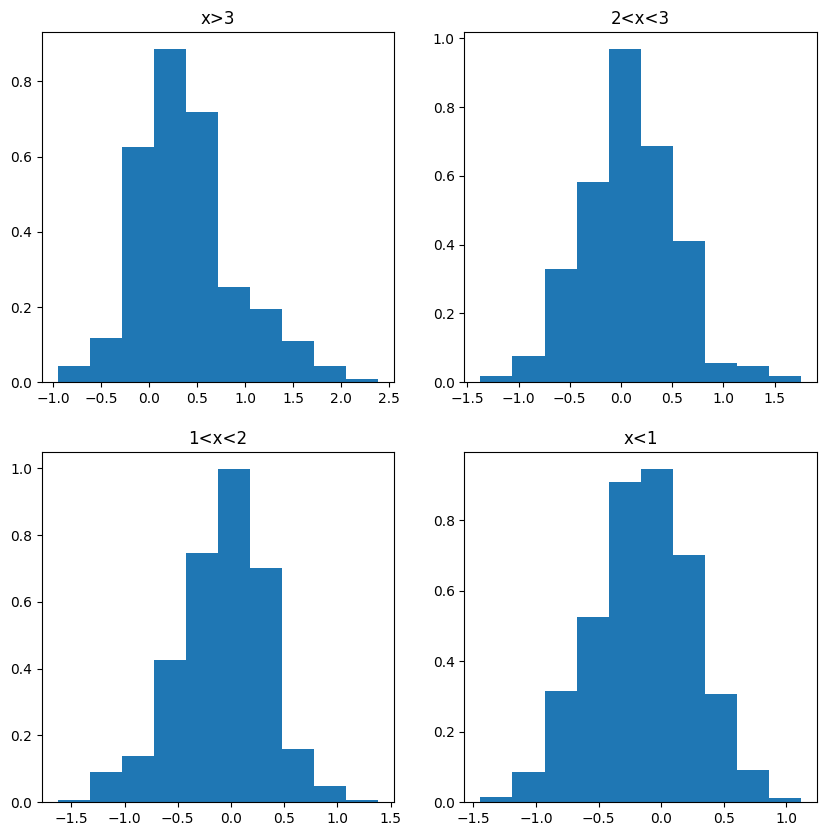

In [11]:
evaluate_wave_error_distr("lasso")

#### ElasticNet

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


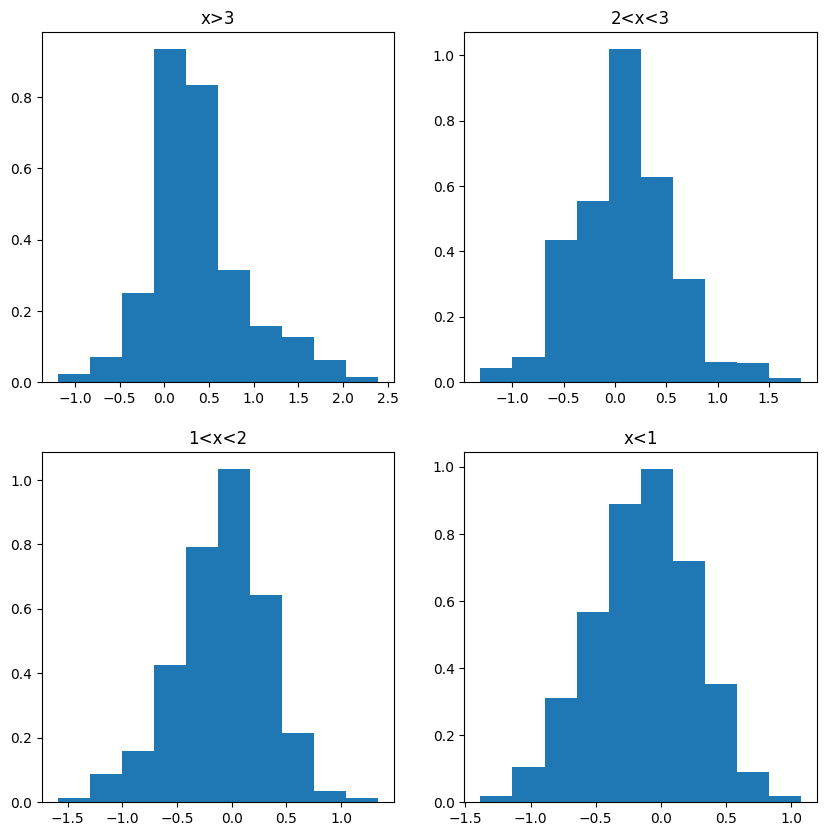

In [15]:
cols = ['moonphase', 'temp', 'rh', 'pressure',
       'vis', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N',
       'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE',
       'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW',
       'wdir_WSW', 'Vviento', 'PeriodoOlas', 'Lluvia', 'Nubosidad']
evaluate_wave_error_distr("sel-elastic", X_test[cols])

Arboles

In [17]:
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'dewPt', 'heat_index',
                                  'rh', 'pressure', 'vis', 'wc', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

In [ ]:
evaluate_wave_error_distr("esc_rf_con_random_search", scaler.transform(X_test))

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


MLP regressor

In [ ]:
evaluate_wave_error_distr("esc-mlp-random-search", scaler.transform(X_test))